# MSiA 420 - Predictive Analytics II - Final Project
## Group 6: Alejandra Lelo de Larrea Ibarra, Kiran Jyothi Sheena, Lixuan (Ellen) Chen, Wencheng Zhang

# Random Forest


In [82]:
# Libraries
import numpy as np
import pandas as pd
import zipfile
import time

from alepython import ale_plot

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix 

## Read data

In [2]:
## Reading the csv file directly from the zip file without extracting it
archive = zipfile.ZipFile('../02_Data/hotel_bookings_ohe.csv.zip', 'r')
files = archive.namelist()
with archive.open(files[0]) as csvfile:   
    df = pd.read_csv(csvfile)

df.head()

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1,is_canceled
0,2015,2,0,0,0,3,0,5.837730,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2015,2,0,0,0,4,0,6.603944,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2015,1,0,0,0,0,0,2.079442,1,0,...,0,0,1,0,0,0,0,1,0,0
3,2015,1,0,0,0,0,0,2.639057,1,0,...,0,0,1,0,0,0,0,1,0,0
4,2015,2,0,0,0,0,1,2.708050,2,0,...,1,0,1,0,0,0,0,1,0,0


In [3]:
# Number of observations and features
df.shape

(119388, 66)

In [4]:
# descriptive stats 
df.describe()

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1,is_canceled
count,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,...,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000
mean,2016.156548,1.856401,0.103888,0.007949,0.087119,0.221103,0.571372,3.840079,3.427865,0.224202,...,0.473054,0.000017,0.773177,0.006684,0.121143,0.089205,0.009792,0.937883,0.062117,0.370414
std,0.707478,0.579266,0.398558,0.097437,0.844343,0.652287,0.792802,1.609797,2.557380,1.827964,...,0.499275,0.004093,0.418779,0.081483,0.326295,0.285041,0.098467,0.241369,0.241369,0.482918
min,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.944439,2.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2016.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.248495,3.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2017.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.081404,4.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2017.000000,55.000000,10.000000,10.000000,26.000000,21.000000,5.000000,6.603944,69.000000,78.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Featrue names 
df.columns

Index(['arrival_date_year', 'adults', 'children', 'babies',
       'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'log_lead_time', 'total_nights',
       'previous_bookings', 'log_days_in_waiting_list', 'log_adr',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'booked_by_agent_no', 'booked_by_agent_yes', 'booked_by_company_0',
       'booked_by_company_1', 'continent_Africa', 'continent_Americas',
       'continent_Antarctica', 'continent_Asia', 'continent_Europe',
       'continent_Oceania', 'continent_unknown', 'customer_type_Contract',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'deposit_type_No Deposit',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'domestic_

## Splitting trianing and test

In [6]:
# get train indexes
train_ind = pd.read_csv("../02_Data/train_index.csv")

# split train
train = df.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)
xtrain = train.drop("is_canceled", axis = 1)
ytrain = train.is_canceled

# Split test 
test = df.iloc[df.index.difference(train_ind.Train_Index),:]
xtest = test.drop("is_canceled", axis = 1)
ytest = test.is_canceled

In [7]:
# Check class imbalance in train and test 
print("Train Class Response:")
print(train.is_canceled.value_counts()/train.shape[0]*100)

print("Test Class Response:")
print(test.is_canceled.value_counts()/test.shape[0]*100)

Train Class Response:
0    62.941441
1    37.058559
Name: is_canceled, dtype: float64
Test Class Response:
0    63.027181
1    36.972819
Name: is_canceled, dtype: float64


## Fit Random Forest with sklearn

In [8]:
# Create random forest object 
rf = RandomForestClassifier(
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)

# Define hyperparameters 
n_estimators = [50, 100, 150, 200, 250, 500, 1000]
min_samples_leaf = [2,3,4,5]
max_features = [1,2,3,4,5]

# dictionary of hyperparams 
hyperparms = dict(n_estimators = n_estimators, 
                 min_samples_leaf = min_samples_leaf, 
                 max_features = max_features)

# Use gridsearch to fit the model 
cv_hyper = GridSearchCV(rf, hyperparms, cv = 10, verbose = 0)
best_mod = cv_hyper.fit(xtrain, ytrain)
                                                                                                                                                                                                                             

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [9]:
# Print best hyperparams 
print("Best number of trees (n_estimators):", best_mod.best_estimator_.get_params()['n_estimators'])
print("Best node size (min_samples_leaf):", best_mod.best_estimator_.get_params()['min_samples_leaf'])
print("Best number of features (max_features):", best_mod.best_estimator_.get_params()['max_features'])

Best number of trees (n_estimators): 1000
Best node size (min_samples_leaf): 2
Best number of features (max_features): 5


## Train best model

In [85]:
# start timer 
train_time = time.time()

# create random forest object with best hyperparams
rf_model = RandomForestClassifier(
    n_estimators = best_mod.best_estimator_.get_params()['n_estimators'], 
    min_samples_leaf = best_mod.best_estimator_.get_params()['min_samples_leaf'], 
    max_features = best_mod.best_estimator_.get_params()['max_features'], 
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=190322)

# Estimate model 
rf_model.fit(xtrain, ytrain)

# end timer 
train_time = time.time() - train_time

In [86]:
# Print train time 
print("Training time: " + str(train_time))

Training time: 19.537066221237183


## Predict test set

In [87]:
# Predictions for test set 
yhat_test = rf_model.predict(xtest)

In [88]:
# --- Evaluation Metrics---
conf_matrix = confusion_matrix(ytest, yhat_test)
print('--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(ytest, yhat_test)))
print('Precision = {:.5f}'.format(precision_score(ytest, yhat_test)))
print('Recall = {:.5f}'.format(recall_score(ytest, yhat_test)))
print('F1 score = {:.5f}'.format(f1_score(ytest, yhat_test)))

--- EVALUATION METRICS ---:

Confusion Matrix:
[[14140   909]
 [ 1891  6937]]

Using 0.5 as threshold:
Accuracy = 0.88273
Precision = 0.88414
Recall = 0.78580
F1 score = 0.83207


/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


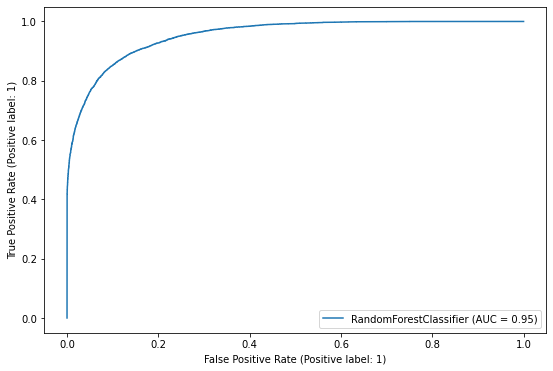

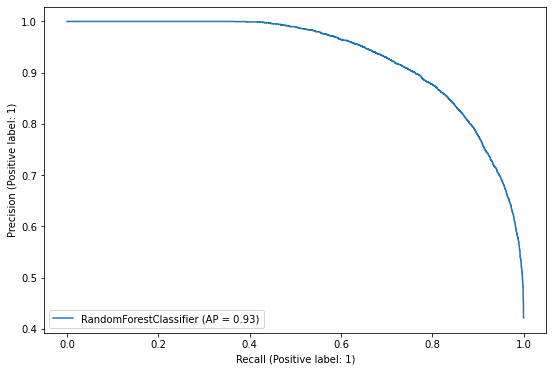

In [89]:
# ROC curve
plot_roc_curve(rf_model, xtest, ytest)

# Precision-recall curve 
plot_precision_recall_curve(rf_model, xtest, ytest)

## Variable Importance

In [90]:
# Get the feature importances
importance = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importance)[::-1]

# Extract dataframe 
var_imp = pd.DataFrame(data = xtrain.columns, columns = ['var'])
var_imp['Importance'] = importance

# Arrange by importance and show top 20 
var_imp.sort_values('Importance', ascending = False, inplace = True)
var_imp.head(20)

,var,Importance
7,log_lead_time,0.120916
40,deposit_type_Non Refund,0.088155
39,deposit_type_No Deposit,0.084286
11,log_adr,0.069461
6,total_of_special_requests,0.062297
43,domestic_international,0.058718
42,domestic_domestic,0.054939
8,total_nights,0.038612
56,market_segment_Online TA,0.032373
4,previous_cancellations,0.029998


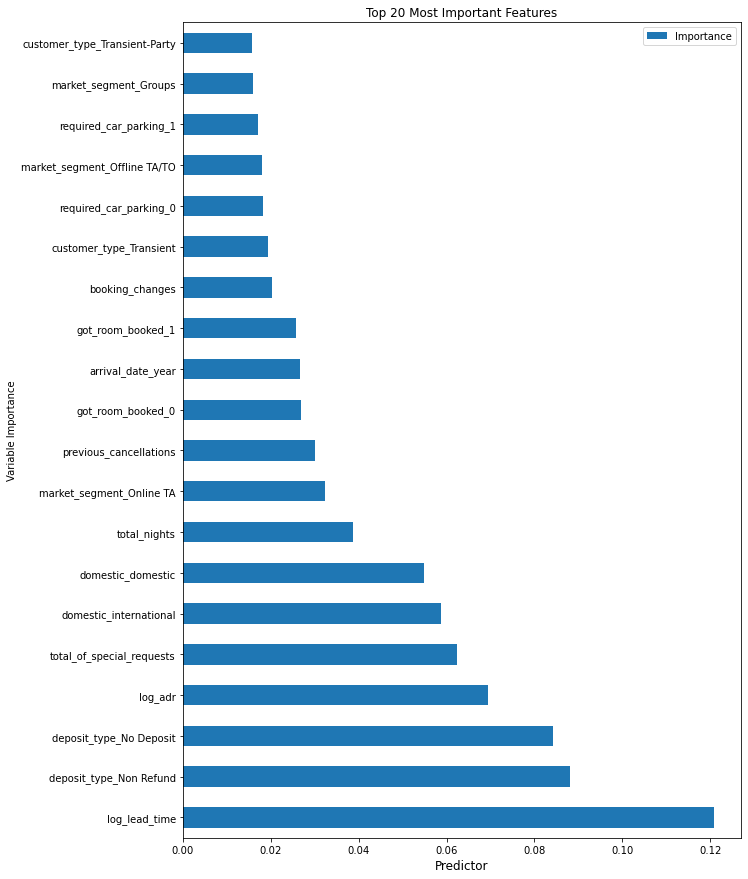

In [91]:
# Plot feature importance
var_imp.iloc[:20,].plot.barh(x='var', y='Importance', figsize=(10,15))
plt.xlabel('Predictor', size = 12) 
plt.ylabel('Variable Importance') 
  
# displaying the title
plt.title("Top 20 Most Important Features")
plt.show()

## ALE PLOTS

### Main Effects

<Figure size 648x432 with 0 Axes>

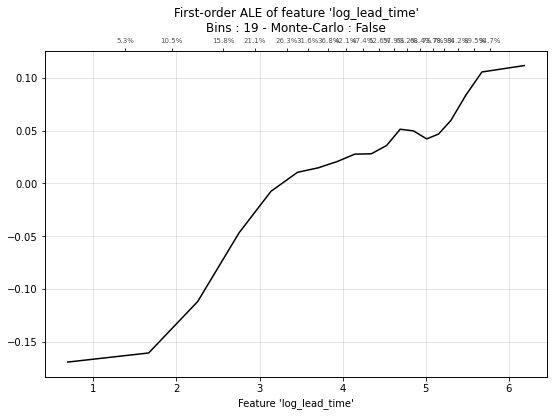

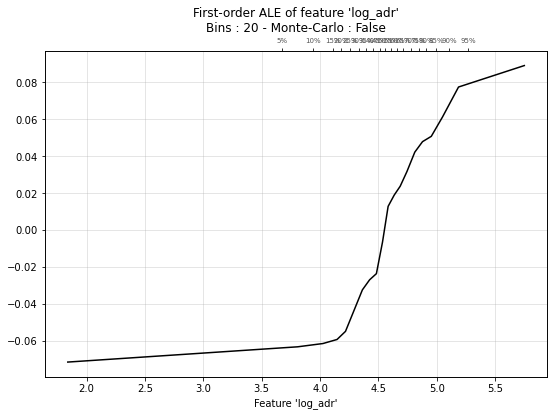

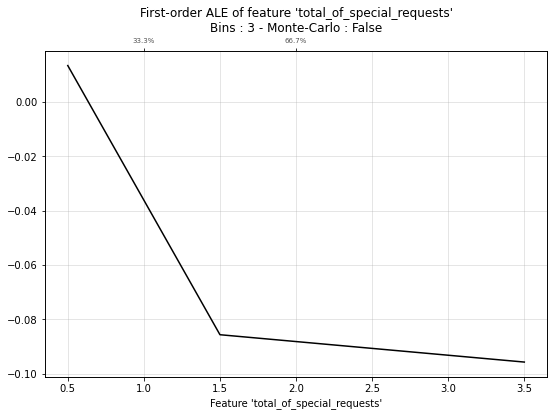

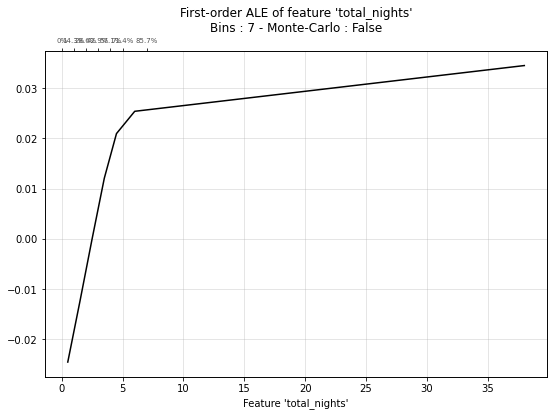

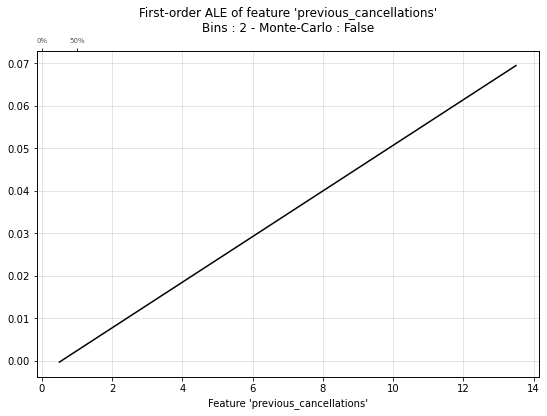

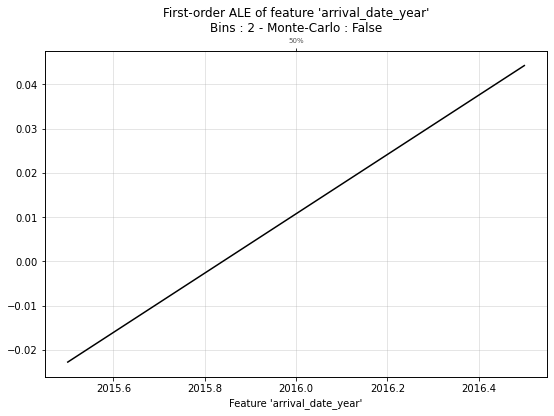

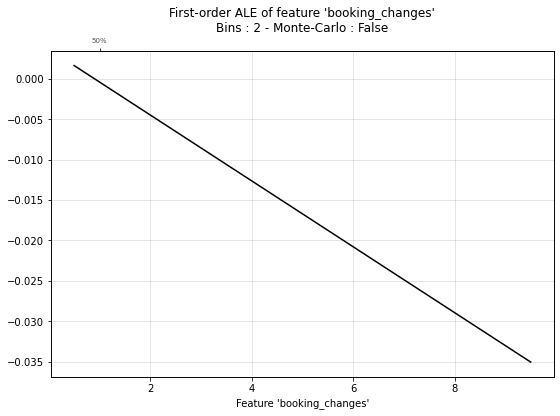

In [92]:
topvar = ["log_lead_time", "log_adr", "total_of_special_requests", 
            "total_nights", "previous_cancellations", "arrival_date_year",
           "booking_changes"]
fig = plt.figure()
for i in range(len(topvar)):
    ale_plot(rf_model, xtrain, topvar[i], bins=20)

### Second Order Effects

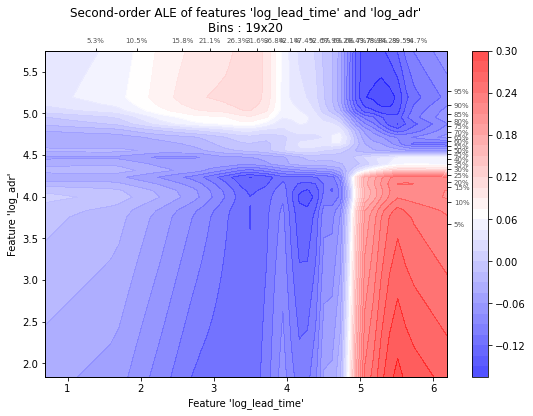

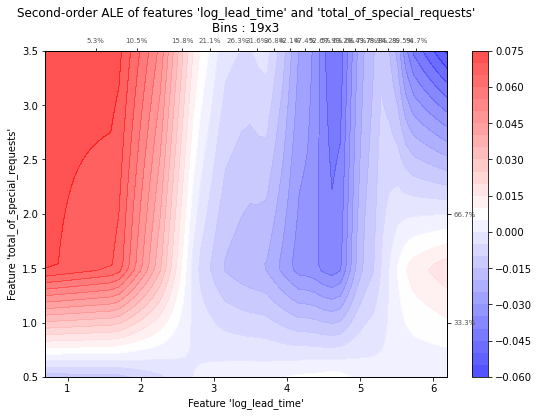

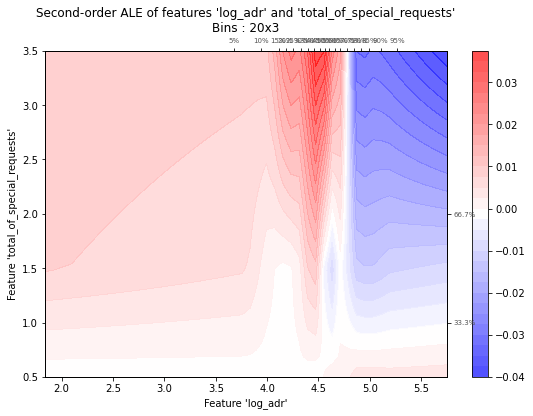

<AxesSubplot:title={'center':"Second-order ALE of features 'log_adr' and 'total_of_special_requests'\nBins : 20x3"}, xlabel="Feature 'log_adr'", ylabel="Feature 'total_of_special_requests'">

In [93]:
plt.rc("figure", figsize = (9,6))
ale_plot(rf_model, xtrain, ["log_lead_time","log_adr"], bins=20)
ale_plot(rf_model, xtrain, ["log_lead_time", "total_of_special_requests"], bins=20)
ale_plot(rf_model, xtrain, ["log_adr", "total_of_special_requests"], bins=20)